In [3]:
# matplotlib 최신 버전 (3.5.x) 반영
!pip install matplotlib==3.5.2

# 설치 후 런타임 재시작

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 8.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


* **visualization setting**

In [4]:
# visualization settings
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")
sns.set_palette("colorblind")

# Data Preparation: penguins dataset


* **stratified data sampling**

In [5]:
df_peng = sns.load_dataset("penguins")
df_peng = df_peng.dropna().reset_index(drop=True)    # 결측치 제거 후 index reset
df_peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [6]:
from sklearn.model_selection import train_test_split

y = df_peng["body_mass_g"]
X = df_peng.drop("body_mass_g", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify=X[["species", "island", "sex"]])

# Pipeline

* **pipeline with Random Forest, LightGBM, XGBoost**

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

def get_model(method="rf",
              cat_features=["species", "island", "sex"], 
              num_features=["bill_length_mm", "bill_depth_mm", "flipper_length_mm"],
              **kwargs):
    # 1-1.categorical feature에 one-hot encoding 적용
    cat_transformer = OneHotEncoder()

    # 1-2.numerical feature는 standard scaler 적용
    num_transformer = StandardScaler()

    # 2. 인자 종류별 전처리 적용
    preprocessor = ColumnTransformer([("cat", cat_transformer, cat_features), 
                                    ("num", num_transformer, num_features)])

    # 3. 전처리 후 입력된 방법론 적용
    if method == "rf":
        ml = ("ml", RandomForestRegressor(**kwargs))
    elif method == "lgbm":
        ml = ("ml", LGBMRegressor(**kwargs))
    elif method == "xgb":
        ml = ("ml", XGBRegressor(**kwargs))

    pipeline = Pipeline(steps=[("preprocessor", preprocessor), 
                               ml])
    
    return pipeline

In [8]:
from sklearn import set_config
set_config(display='diagram')

In [9]:
from sklearn.ensemble import RandomForestRegressor

model = get_model(method="rf")

In [10]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['species', 'island', 'sex']),
                                                 ('num', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm'])])),
                ('ml', RandomForestRegressor())])

* **Decision Tree Visualizer**

In [11]:
import io
import pydot
from IPython.core.display import Image
from sklearn.tree import export_graphviz


def draw_decision_tree(model, 
                       feature_names=["bill_length_mm", "bill_depth_mm", "flipper_length_mm",
                                      "species_Adelie", "species_Chinstrap", "species_Gentoo", 
                                      "island_Biscoe", "island_Dream", "island_Torgersen", 
                                      "sex_Female", "sex_Male"]):
    dot_buf = io.StringIO()
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0]
    image = graph.create_png()
    return Image(image)

100


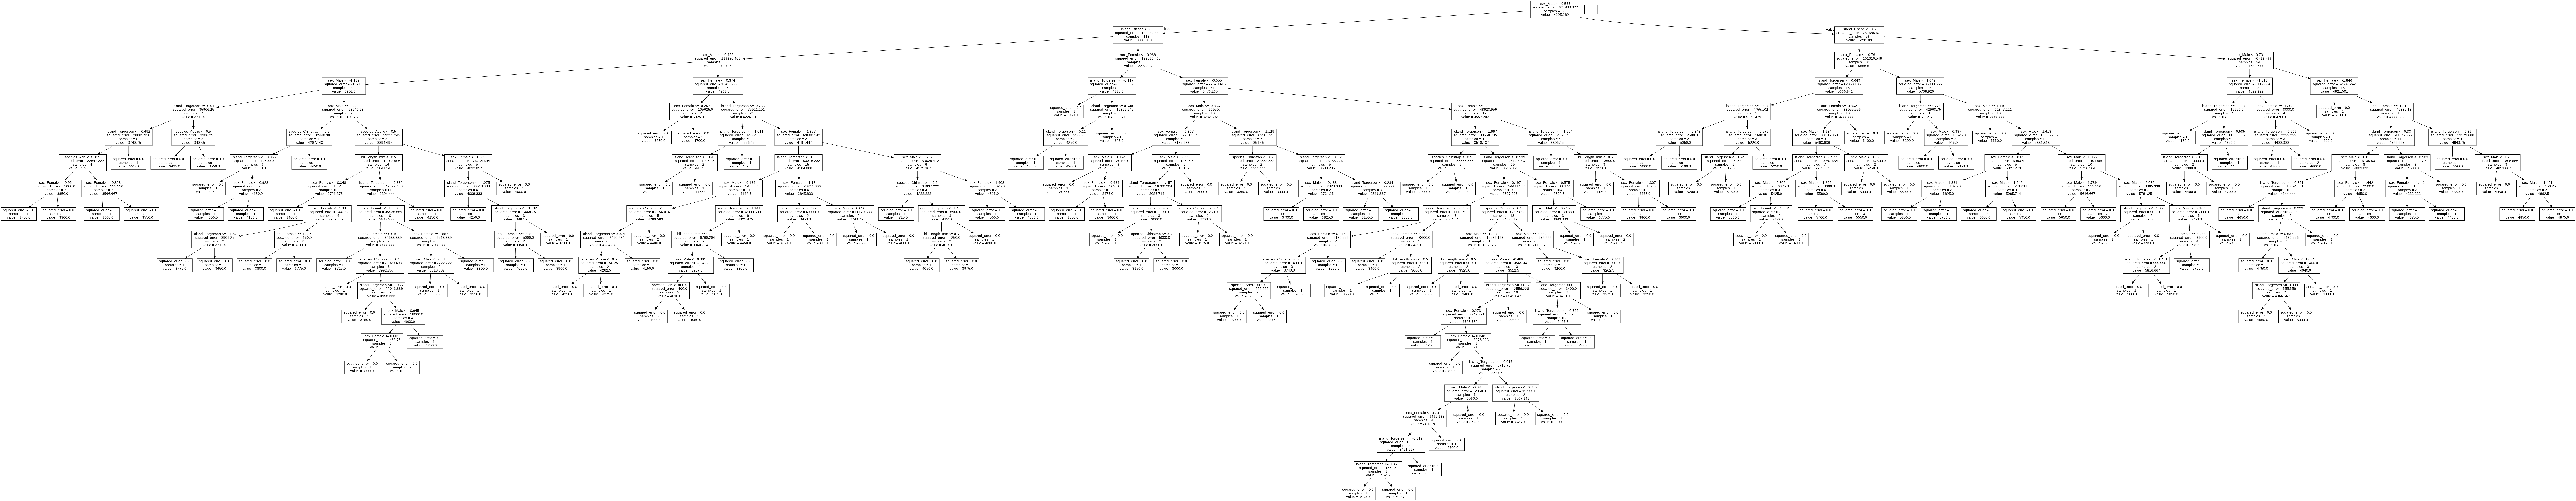

In [12]:
dts = model["ml"].estimators_
print(len(dts))
draw_decision_tree(dts[2])

In [13]:
model["ml"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

* **Visualization code: parity plot**

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

c_train = "g"
c_val = "m"

def get_parity(y_train, y_val, y_pred_train, y_pred_val):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5.5), constrained_layout=True, sharex=True, sharey=True)
    for ax, y_true, y_pred, c, title in zip(axs, [y_train, y_val], [y_pred_train, y_pred_val], [c_train, c_val], ["train", "valid"]):
        ax.scatter(y_true, y_pred, c=c)
        ax.set_xlabel("true", color="gray", labelpad=12)
        if ax == axs[0]:
            ax.set_ylabel("prediction", color="gray", labelpad=12)
        ax.set_title(title, color="gray", pad=12)

        r2 = r2_score(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)

        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        limmin = min(xmin, ymin)
        limmax = max(xmax, ymax)
        ax.plot([limmin, limmax], [limmin, limmax], c="k", alpha=0.5)
        ax.set_xlim(limmin, limmax)
        ax.set_ylim(limmin, limmax)

        ax.text(0.95, 0.05, f"R2 = {r2:.3f}\nRMSE = {rmse:.3f}", ha="right", transform=ax.transAxes, fontsize=16)
    return fig, r2

* **Test Run**

In [15]:
import time

def timelog(fn):
    def wrap_fn(*args, **kwargs):
        time_start = time.time()
        result = fn(*args, **kwargs)
        time_end = time.time()
        print(f"# running time: {time_end-time_start:.2f} sec.")
        return result
    return wrap_fn

@timelog
def fit_pipeline(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# running time: 0.51 sec.


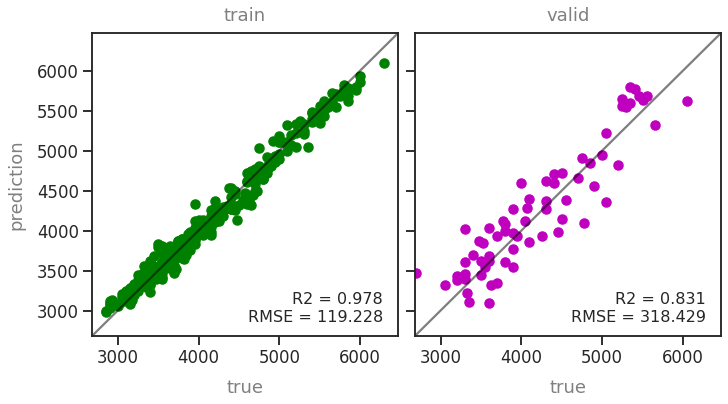

In [16]:
import time

# model 생성
model_default = get_model(method="rf", random_state=0)

# model 학습 & 학습 시간 측정
time_start = time.time()
model = model_default.fit(X_train, y_train)
time_end = time.time()
print(f"# running time: {time_end-time_start:.2f} sec.")

# model 예측
y_pred_train = model_default.predict(X_train)
y_pred_val = model_default.predict(X_val)

fig, r2_default = get_parity(y_train, y_val, y_pred_train, y_pred_val)

# Hyperparameter Optimization

* **(1) Grid Search**

In [17]:
from sklearn.model_selection import GridSearchCV

# parameter grid
params = {"ml__n_estimators": [100, 200, 300],
          "ml__max_depth": [3, 5, 10],
          "ml__min_samples_leaf": [1, 3, 5, 7, 10],
          "ml__max_features": ["auto", "sqrt", "log2"]
          }

# GridSearchCV Pipeline 생성
model = get_model(method="rf", random_state=0)
gscv = GridSearchCV(model, param_grid=params, scoring="r2", refit="r2")

# GridSearchCV 학습 & 학습 시간 측정
time_start = time.time()
gscv.fit(X_train, y_train)
time_end = time.time()
time_gscv = time_end-time_start
print(f"# running time: {time_gscv:.2f} sec.")

gscv

# running time: 190.62 sec.


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         ['species',
                                                                          'island',
                                                                          'sex']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['bill_length_mm',
                                                                          'bill_depth_mm',
                                                                          'flipper_length_mm'])])),
                                       ('ml',
                                        RandomForestRegressor(random_state=0))]),
             param_grid={'ml__max_depth': [3, 5, 10],
                         'ml__max_features': ['auto', 'sqrt', 'log2'],
                         'ml__min_samples_leaf': [1, 3, 5, 7, 10],
                         'ml__n_estimators': [100, 200, 300]},
             refit='r2', scoring='r2')

In [18]:
import pandas as pd

pd.DataFrame.from_dict(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.243501,0.020041,0.024557,0.005612,3,auto,1,100,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.846898,0.881006,0.793560,0.858915,0.842726,0.844621,0.028790,129
1,0.526691,0.044874,0.037372,0.004135,3,auto,1,200,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.852114,0.880772,0.791440,0.861396,0.844448,0.846034,0.029875,122
2,0.733786,0.050523,0.069781,0.035682,3,auto,1,300,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.851153,0.882564,0.791061,0.861333,0.845969,0.846416,0.030384,119
3,0.287122,0.054537,0.026414,0.009246,3,auto,3,100,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.848270,0.883037,0.790511,0.860140,0.842808,0.844953,0.030531,128
4,0.547937,0.044021,0.037100,0.006200,3,auto,3,200,"{'ml__max_depth': 3, 'ml__max_features': 'auto...",0.852483,0.883479,0.789316,0.861675,0.843813,0.846153,0.031338,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.245311,0.024154,0.021194,0.005379,10,log2,7,200,"{'ml__max_depth': 10, 'ml__max_features': 'log...",0.860722,0.891264,0.830271,0.861100,0.834478,0.855567,0.021982,45
131,0.503228,0.083535,0.035589,0.006249,10,log2,7,300,"{'ml__max_depth': 10, 'ml__max_features': 'log...",0.860311,0.890730,0.830879,0.861505,0.835659,0.855817,0.021446,41
132,0.120256,0.003930,0.013154,0.001764,10,log2,10,100,"{'ml__max_depth': 10, 'ml__max_features': 'log...",0.855474,0.882651,0.817177,0.853363,0.836557,0.849044,0.021729,78
133,0.229354,0.003448,0.020219,0.003952,10,log2,10,200,"{'ml__max_depth': 10, 'ml__max_features': 'log...",0.855929,0.878403,0.821909,0.853892,0.829200,0.847867,0.020278,98


In [19]:
# best hyperparameters
print(gscv.best_params_)

# best score
print(gscv.best_score_)
gscv_best = gscv.best_score_

{'ml__max_depth': 5, 'ml__max_features': 'sqrt', 'ml__min_samples_leaf': 1, 'ml__n_estimators': 200}
0.8652010118792628


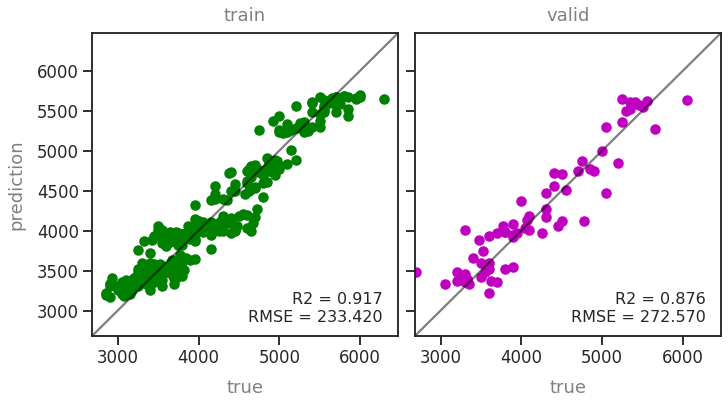

In [20]:
y_pred_train = gscv.predict(X_train)
y_pred_val = gscv.predict(X_val)
fig, r2_gsval = get_parity(y_train, y_val, y_pred_train, y_pred_val)

* **(2) Random Search CV**

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# parameter distribution
params = {"ml__n_estimators": stats.randint(100, 300),   # [100, 200, 300]
          "ml__max_depth": stats.randint(3, 10),         # [3, 5, 10],
          "ml__min_samples_leaf": stats.randint(1, 10),  # [1, 3, 5, 7, 10]
          "ml__max_features": stats.uniform(0, 1),       # ["auto", "sqrt", "log2"]
          }

# RandomizedSearchCV Pipeline 생성
model = get_model(method="rf", random_state=0)
rscv = RandomizedSearchCV(model, param_distributions=params, # param_grid
                          n_iter=30,                         # number of HP sampling
                          scoring="r2", refit="r2")

# RandomizedSearchCV 학습 & 학습 시간 측정
time_start = time.time()
rscv.fit(X_train, y_train)
time_end = time.time()
time_rscv = time_end-time_start
print(f"# running time: {time_rscv:.2f} sec.")

# running time: 40.33 sec.


In [22]:
pd.DataFrame.from_dict(rscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.133803,0.004496,0.011905,0.000718,6,0.972353,9,101,"{'ml__max_depth': 6, 'ml__max_features': 0.972...",0.846394,0.895956,0.810721,0.860576,0.849742,0.852678,0.027364,26
1,0.183855,0.003362,0.015830,0.001384,8,0.916996,4,136,"{'ml__max_depth': 8, 'ml__max_features': 0.916...",0.850565,0.897160,0.815710,0.866281,0.852515,0.856446,0.026320,12
2,0.144660,0.004118,0.012739,0.000691,3,0.811122,2,115,"{'ml__max_depth': 3, 'ml__max_features': 0.811...",0.850284,0.885439,0.810768,0.865727,0.847373,0.851918,0.024621,28
3,0.237171,0.005205,0.017115,0.000202,9,0.916385,4,180,"{'ml__max_depth': 9, 'ml__max_features': 0.916...",0.851925,0.895725,0.812036,0.865193,0.851163,0.855208,0.026953,16
4,0.275749,0.007237,0.020469,0.001236,4,0.862983,3,220,"{'ml__max_depth': 4, 'ml__max_features': 0.862...",0.856926,0.892764,0.823062,0.866514,0.847408,0.857335,0.022860,9
5,0.257825,0.006396,0.018858,0.000231,8,0.379906,1,202,"{'ml__max_depth': 8, 'ml__max_features': 0.379...",0.853470,0.894513,0.852626,0.864098,0.842383,0.861418,0.017918,2
6,0.186370,0.007639,0.014903,0.000293,4,0.563475,1,150,"{'ml__max_depth': 4, 'ml__max_features': 0.563...",0.860076,0.891504,0.841720,0.868116,0.846389,0.861561,0.017695,1
7,0.272528,0.009853,0.022538,0.002121,5,0.300764,7,229,"{'ml__max_depth': 5, 'ml__max_features': 0.300...",0.859155,0.889104,0.830018,0.862677,0.834906,0.855172,0.021293,17
8,0.201662,0.013418,0.016596,0.002592,9,0.583608,6,164,"{'ml__max_depth': 9, 'ml__max_features': 0.583...",0.855157,0.901328,0.830816,0.866282,0.846231,0.859963,0.023716,4
9,0.315719,0.004070,0.024657,0.004452,8,0.77083,4,248,"{'ml__max_depth': 8, 'ml__max_features': 0.770...",0.851283,0.901754,0.826600,0.866176,0.856740,0.860511,0.024423,3


In [23]:
# best hyperparameters
print(rscv.best_params_)

# best score
print(rscv.best_score_)
rscv_best = rscv.best_score_

{'ml__max_depth': 4, 'ml__max_features': 0.5634751247689049, 'ml__min_samples_leaf': 1, 'ml__n_estimators': 150}
0.8615610499524327


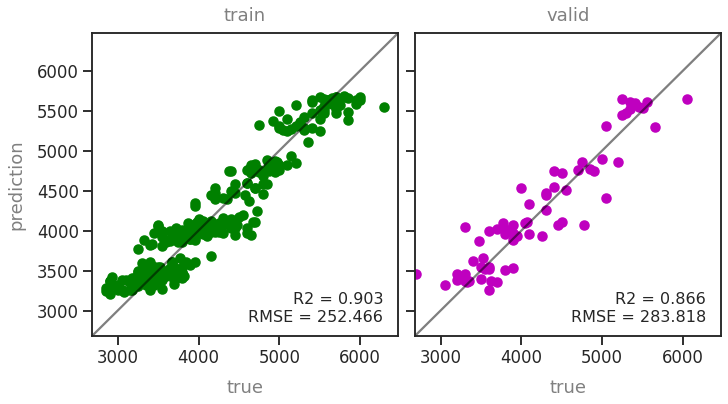

In [24]:
y_pred_train = rscv.predict(X_train)
y_pred_val = rscv.predict(X_val)
fig, r2_rsval = get_parity(y_train, y_val, y_pred_train, y_pred_val)

* **(3) Bayesian Search CV**

In [25]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

# parameter distribution
params = {"ml__n_estimators": Integer(100, 300),        # [100, 200, 300]
          "ml__max_depth": Integer(3, 10),              # [3, 5, 10],
          "ml__min_samples_leaf": Integer(1, 10),       # [1, 3, 5, 7, 10]
          "ml__max_features": Categorical(["auto", "sqrt", "log2"]) # ["auto", "sqrt", "log2"]
          }

# BayesSearchCV Pipeline 생성
model = get_model(method="rf", random_state=0)
bscv = BayesSearchCV(model, search_spaces=params,  # param_grid
                     n_iter=30,                    # number of HP sampling
                     cv=5,                         # number of folds in CV 
                     scoring="r2", refit="r2")

# BayesSearchCV 학습 & 학습 시간 측정
time_start = time.time()
bscv.fit(X_train, y_train)
time_end = time.time()
time_bscv = time_end-time_start
print(f"# running time: {time_bscv:.2f} sec.")

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


# running time: 89.98 sec.


In [27]:
pd.DataFrame.from_dict(bscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml__max_depth,param_ml__max_features,param_ml__min_samples_leaf,param_ml__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.202507,0.059613,0.019495,0.006441,10,sqrt,8,131,"{'ml__max_depth': 10, 'ml__max_features': 'sqr...",0.857777,0.890292,0.827738,0.862217,0.836659,0.854937,0.021840,18
1,0.329682,0.055993,0.021758,0.001002,8,log2,5,239,"{'ml__max_depth': 8, 'ml__max_features': 'log2...",0.859683,0.893714,0.837171,0.862424,0.839167,0.858432,0.020423,15
2,0.193323,0.003663,0.017556,0.003009,4,log2,4,164,"{'ml__max_depth': 4, 'ml__max_features': 'log2...",0.864716,0.884585,0.839060,0.859765,0.835382,0.856701,0.017982,16
3,0.136222,0.031057,0.018862,0.011679,4,log2,10,101,"{'ml__max_depth': 4, 'ml__max_features': 'log2...",0.853591,0.881898,0.816468,0.856097,0.833037,0.848218,0.022198,25
4,0.661814,0.106312,0.043515,0.001936,7,log2,7,276,"{'ml__max_depth': 7, 'ml__max_features': 'log2...",0.861320,0.890722,0.831936,0.861681,0.836662,0.856464,0.021062,17
5,0.303965,0.021467,0.028072,0.006629,7,sqrt,4,123,"{'ml__max_depth': 7, 'ml__max_features': 'sqrt...",0.859197,0.895355,0.841050,0.861983,0.846284,0.860774,0.018967,12
6,0.320323,0.066951,0.021441,0.002552,9,auto,6,106,"{'ml__max_depth': 9, 'ml__max_features': 'auto...",0.847297,0.891069,0.799162,0.865336,0.851859,0.850945,0.030042,21
7,0.545410,0.046264,0.047412,0.004907,4,sqrt,9,242,"{'ml__max_depth': 4, 'ml__max_features': 'sqrt...",0.857613,0.877695,0.823369,0.857970,0.828066,0.848943,0.020363,22
8,0.598121,0.021677,0.043454,0.009051,4,auto,5,220,"{'ml__max_depth': 4, 'ml__max_features': 'auto...",0.853211,0.892658,0.795730,0.866595,0.847664,0.851172,0.031778,20
9,0.429862,0.007721,0.033692,0.004944,4,sqrt,2,189,"{'ml__max_depth': 4, 'ml__max_features': 'sqrt...",0.864596,0.881800,0.848776,0.864267,0.840710,0.860030,0.014231,13


In [28]:
# best hyperparameters
print(bscv.best_params_)

# best score
print(bscv.best_score_)
bscv_best = bscv.best_score_

OrderedDict([('ml__max_depth', 9), ('ml__max_features', 'sqrt'), ('ml__min_samples_leaf', 2), ('ml__n_estimators', 300)])
0.8656397770278467


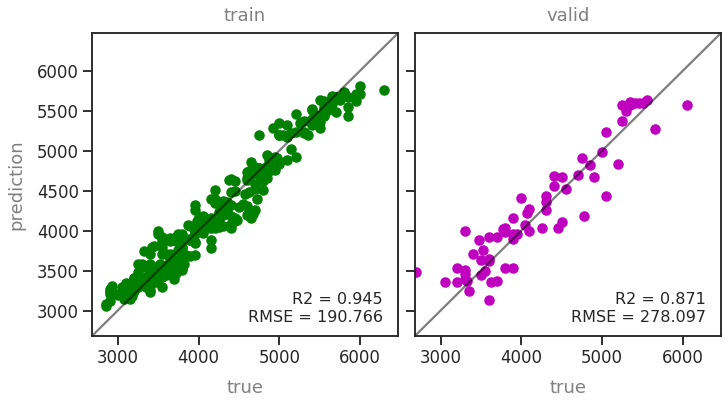

In [29]:
y_pred_train = bscv.predict(X_train)
y_pred_val = bscv.predict(X_val)
fig, r2_bsval = get_parity(y_train, y_val, y_pred_train, y_pred_val)

* **summary**

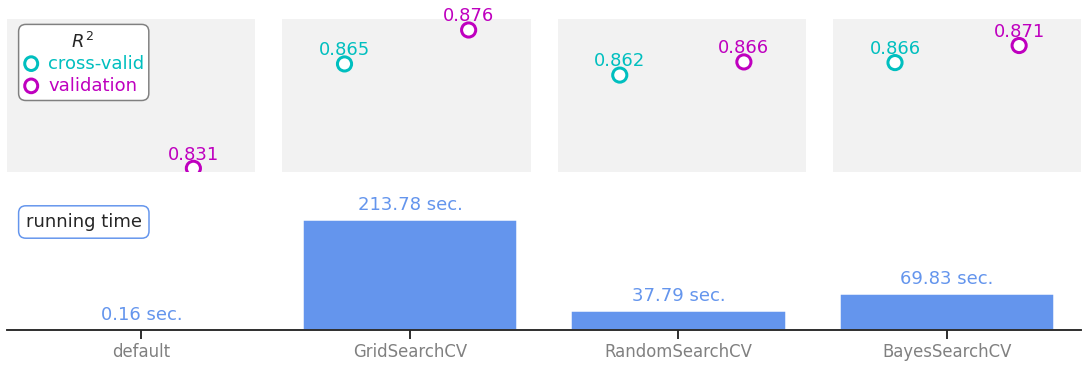

In [31]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

fig = plt.Figure(figsize=(15, 5), constrained_layout=True)
sfigs = fig.subfigures(nrows=2, hspace=0.1)

axs_R2 = sfigs[0].subplots(ncols=4, sharex=True, sharey=True, gridspec_kw={"wspace":0.1})
R2_cvs = [-1, gscv_best, rscv_best, bscv_best]
R2_vals = [r2_default, r2_gsval, r2_rsval, r2_bsval]

for ax, R2_cv, R2_val in zip(axs_R2, R2_cvs, R2_vals):
    ax.scatter([0, 1], [R2_cv, R2_val], fc="w", ec=["c", "m"], lw=3, s=200)
    if ax in axs_R2[1:]:
        ax.text(0, R2_cv+0.003, f"{R2_cv:.3f}", ha="center", color="c")
    ax.text(1, R2_val+0.003, f"{R2_val:.3f}", ha="center", color="m")
    ax.set(xlim=(-0.5, 1.5), ylim=(0.83, 0.88), xticks=[], yticks=[])
    ax.spines[:].set_visible(False)
    ax.set_fc("0.95")

sfigs[0].text(0.02, 0.5, "        $R^2$         \n\n", transform=sfigs[0].transSubfigure, 
           bbox={"boxstyle":"round", "fc":"w", "ec":"gray", "pad":0.4})
marker0 = Ellipse((0.025, 0.65), 0.012, 0.08, ec="c", fc="w", lw=3, zorder=10)
marker1 = Ellipse((0.025, 0.52), 0.012, 0.08, ec="m", fc="w", lw=3, zorder=10)
sfigs[0].add_artist(marker0)
sfigs[0].add_artist(marker1)
sfigs[0].text(0.041, 0.62, "cross-valid", color="c", transform=sfigs[0].transSubfigure)
sfigs[0].text(0.041, 0.49, "validation", color="m", transform=sfigs[0].transSubfigure)


ts = [0.16, 213.78, 37.79, 69.83]
axs_t = sfigs[1].subplots()
axs_t.bar([0, 1, 2, 3], ts, color="cornflowerblue")
axs_t.set(xlim=(-0.5, 3.5), xticks=[0, 1, 2, 3], yticks=[])
axs_t.set_xticklabels(["default", "GridSearchCV", "RandomSearchCV", "BayesSearchCV"], color="gray")
for p in axs_t.patches:
    h = p.get_height()
    x = p.get_x()
    w = p.get_width()
    axs_t.text(x+w/2, h+20, f"{h} sec.", color="cornflowerblue", ha="center")
axs_t.spines[:].set_visible(False)
axs_t.spines["bottom"].set_visible(True)
sfigs[1].text(0.02, 0.8, "running time", transform=sfigs[1].transSubfigure, 
           bbox={"boxstyle":"round", "fc":"w", "ec":"cornflowerblue", "pad":0.4})

display(fig)